# NYC-Taxi-FHV-Project


In [1]:
import pandas as pd #DataFrame
import numpy as np #For array
import os #for os commands
from math import sin, cos, sqrt, atan2, radians, log #For calculation
import time           #to get the system time
import datetime       #for datetime operations
import holidays       #For extract date time of holidays
import calendar       #For calendar for datetime operations


pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="E:/GitHub/NYU-Taxi-project/My First Project-b3735f3b3a9d.json"
#os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./My Project 14295-223aab171173.json"
from google.cloud import bigquery
client = bigquery.Client()

#For geospatial data
import geopandas as gpd   #For geospatial data
import shapely
import pysal as ps
from fiona.crs import from_epsg
from shapely.geometry import Polygon
import geohash_hilbert as ghh # For geohash code
#import choroplethNYC as cp #For taxi zone map

#For machine learning models
import sklearn
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge #For lasso and ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

#For visualization purpose
from scipy.misc import imread, imresize, imsave 
from pandas.plotting import scatter_matrix
import scipy         #for other dependancies
import seaborn as sns #for making plots
from scipy.misc import imread, imresize, imsave  
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from IPython.display import HTML
from matplotlib.pyplot import *
from matplotlib import cm
from matplotlib import animation
from scipy.misc import imread, imresize, imsave  
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

E:\Program Files\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql
E:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 1. Data Processing

### 1.1 Query Data from BigQuery

In [2]:
start = time.time()
query = (
"""
SELECT x.travel_time, x.date, x.month, x.day, pickup_hour, pickup_datetime, dropoff_datetime,
    pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude,passenger_count,
    temp,visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
FROM
(
      SELECT *,ROW_NUMBER() OVER(partition by date, pickup_hour) as row_number
      FROM
      (
            SELECT pickup_datetime, dropoff_datetime, pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude,
            EXTRACT (HOUR FROM pickup_datetime) as pickup_hour,
            EXTRACT (DAY FROM pickup_datetime) as day,
            EXTRACT (MONTH FROM pickup_datetime) as month,
            EXTRACT (DATE FROM pickup_datetime) as date,
            TIMESTAMP_DIFF(TIMESTAMP(dropoff_datetime), TIMESTAMP(pickup_datetime), SECOND) as travel_time,
            passenger_count
            FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
            WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL and
                dropoff_longitude IS NOT NULL and dropoff_latitude IS NOT NULL
      ) x
      where x.travel_time >0
) x
JOIN
(
 select cast(mo as int64) as month,cast(da as int64) as day,temp,visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
 from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
) y on x.month = y.month and x.day = y.day
where x.row_number <= 400
"""
)
data = pd.io.gbq.read_gbq(query,dialect='standard')
       
end = time.time()
print("Time taken by above cell is {} mins.".format(round((end-start)/60,2)))

Time taken by above cell is 9.79 mins.


### 1.1.1 Define Trip Distance

In [3]:
# great circle distance
def haversine_(lat1, lng1, lat2, lng2):
    """calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

# manhattan distance
def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

data['haversine_distance'] = round(haversine_(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude),3)
data['manhattan_distance'] = round(manhattan_distance_pd(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude),3)

### 1.2 Remove Outlier

###  1.2.1 Remove Short & Large Distance

#### Some passengers get on taxi then get off immediately, so the time and distance is near zero. Many rows do have zero for pickup or drop off location or almost same location for pick up and drop off. 

#### Therefore, we are only considered the travel time is at least 60 second and no longer than 5 hours. And, we investage on the distance between 0 and 50 miles

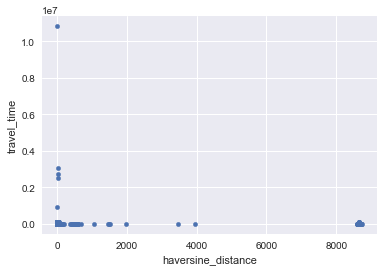

In [4]:
data.plot(x='haversine_distance',y='travel_time',kind='scatter')

In [6]:
data.loc[(data.haversine_distance == 0) & (data.travel_time <= 60), ['travel_time', 'haversine_distance']].head(10)

,travel_time,haversine_distance
463,5,0.0
1430,25,0.0
1620,23,0.0
2514,28,0.0
2854,19,0.0
2874,31,0.0
3010,7,0.0
3514,3,0.0
3813,3,0.0
4328,4,0.0


In [7]:
data = data.loc[(data['haversine_distance'] > 0.5) & (data['haversine_distance']<50)]

###  1.2.2 Remove Short & Large Trip Time

#### In NYC

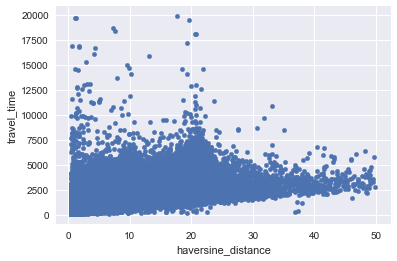

In [8]:
data = data.loc[(data['travel_time'] > 60) & (data['travel_time'] < 20000)]
data.plot(x='haversine_distance',y='travel_time',kind='scatter')

### 1.2.3 Clean GPS Coordinates

In [9]:
# clean any pickup not in the NYC
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
data = data[(data.pickup_longitude> xlim[0]) & (data.pickup_longitude < xlim[1])]
data = data[(data.dropoff_longitude> xlim[0]) & (data.dropoff_longitude < xlim[1])]
data = data[(data.pickup_latitude> ylim[0]) & (data.pickup_latitude < ylim[1])]
data = data[(data.dropoff_latitude> ylim[0]) & (data.dropoff_latitude < ylim[1])]

### 1.2.4 Remove No Passenger Trip

In [10]:
data = data.loc[data.passenger_count > 0]

### 1.2.5 Clean Weather Data

In [11]:
# refill visib using forward or backward
data['visib'] = data['visib'].replace(999.9, np.nan).fillna(method='ffill')

# refill mxpsd using forward or backward
data['mxpsd'] = data['mxpsd'].replace(999.9, np.nan).fillna(method='ffill')              

# refill wdsp using forward or backward
data['wdsp'] = data['wdsp'].replace(999.9, np.nan).fillna(method='ffill')              

# refill gust as 0
data.loc[(data['gust'] == 999.9), 'gust'] = 0

# refit sndp as 0
data.loc[data['sndp'] == 999.9, 'sndp'] = 0

## 2. Exploratory Data Analysis & Process

### Trip Duration vs Hours, Day of Week and Month

#### Hourly Duration

In [ ]:
summary_hour_duration = pd.DataFrame(data.groupby('pickup_hour')['travel_time'].median())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_hour_duration, time="pickup_hour", unit = "unit", value="travel_time")
sns.despine(bottom = True)

In [ ]:
summary_hour_duration = pd.DataFrame(data.groupby(['weekday','pickup_hour'])['travel_time'].median())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_hour_duration, time="pickup_hour", unit = "unit", condition="weekday", value="travel_time")
sns.despine(bottom = True)

In [ ]:
heatmap_data1 = summary_hour_duration.pivot(index = 'weekday',columns = 'pickup_hour',values = 'travel_time')
fig,ax=plt.subplots(figsize = (20,7))
plt.title('Hourly duration by weekday')
sns.heatmap(heatmap_data1, cbar_kws={'label': 'Median Duration'}, cmap="YlGn")

In [ ]:
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="pickup_hour", y="travel_time", data=data, palette="PRGn")
plt.ylim(120, 5000)
sns.despine(offset=10, trim=True)
print(data.travel_time.max())

####  Weekly Durations

In [ ]:
summary_week_duration = pd.DataFrame(data.groupby(['weekday'])['travel_time'].median())
summary_week_duration.reset_index(inplace = True)
summary_week_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_week_duration, time="weekday", unit = "unit", value="travel_time")
sns.despine(bottom = True)

In [ ]:
summary_weekday_duration = pd.DataFrame(data.groupby(['weekday','month_of_year'])['travel_time'].median())
summary_weekday_duration.reset_index(inplace = True)
summary_weekday_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_weekday_duration, time="weekday", unit = "unit", condition="month_of_year", value="travel_time")
sns.despine(bottom = True)

In [ ]:
heatmap_data2 = summary_weekday_duration.pivot(index = 'month_of_year',columns = 'weekday',values = 'travel_time')
fig,ax=plt.subplots(figsize = (20,7))
plt.title('Hourly duration by weekday')
ax.axis
sns.heatmap(heatmap_data2, cbar_kws={'label': 'Median Duration'}, cmap="YlGn")

In [ ]:
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="weekday", y="travel_time", data=data, palette="PRGn")
plt.ylim(0, 5000)
sns.despine(offset=10, trim=True)
print(data.travel_time.max())

#### Monthly Duration

In [ ]:
summary_month_duration = pd.DataFrame(data.groupby(['month_of_year'])['travel_time'].median())
summary_month_duration.reset_index(inplace = True)
summary_month_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_month_duration, time="month_of_year", unit = "unit", value="travel_time")
sns.despine(bottom = True)

In [ ]:
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="month_of_year", y="travel_time", data=data, palette="PRGn")
plt.ylim(0, 5000)
sns.despine(offset=10, trim=True)
print(data.travel_time.max())

### Passenger count

In [ ]:
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="passenger_count", y="travel_time", data=data, palette="PRGn")
plt.ylim(0, 5000)
sns.despine(offset=10, trim=True)
print(data.travel_time.max())

### Summary of Weather Data

In [ ]:
df_weather = pd.read_csv("./Data/tables/weather_2016_cleaned.csv")

In [ ]:
df_weather.boxplot(figsize=(30,5))

In [ ]:
df_weather.hist(figsize=(8,15))

In [ ]:
corr = df_weather.corr()
cmap = sns.diverging_palette(250, 10, sep=20, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap)

### Weather vs Trip Duration

In [ ]:
df = data[['date_of_year','travel_time', 'temp','visib','mxpsd', 'wdsp', 'gust', 'max', 'min', 'prcp', 'sndp', 
             'fog', 'rain_drizzle', 'snow_ice_pellets', 'hail', 'thunder']]
corr = df.corr()
cmap = sns.diverging_palette(250, 10, sep=20, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap)

## 3. Feature Engineer

### 3.1 Transformation of Trip Duration

In [ ]:
sns.set(style="white", palette="muted", color_codes=True)
ff, axes = plt.subplots(1,1, figsize=(8, 6), sharex=True)
sns.despine(left=True)

sns.distplot(data['travel_time'].values+1, axlabel = 'Distance', label = 'Histogrqm of Distance', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()

E:\Program Files\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


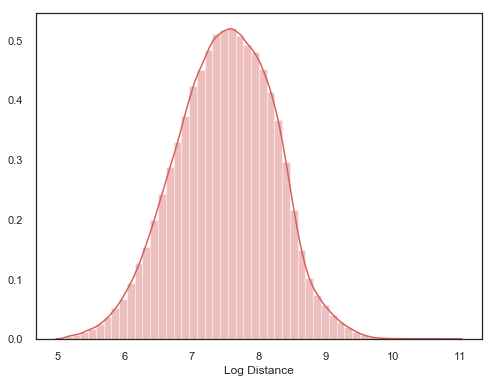

In [12]:
data['travel_time'] = np.log(data['travel_time']).values+1

sns.set(style="white", palette="muted", color_codes=True)
ff, axes = plt.subplots(1,1, figsize=(8, 6), sharex=True)
sns.distplot(data['travel_time'], axlabel = 'Log Distance', label = 'Histogrqm of Distance', bins = 50, color="r")


### 3.2 Weekday

In [13]:
data['weekday'] = data['date'].dt.weekday

### 3.3 Holiday

In [14]:
us_holidays = holidays.UnitedStates()
data['holiday'] = data['date'].apply(lambda x: 1 if x in us_holidays else 0)

### 3.4 Rush Hour

In [15]:
# create dummy for rush hour
data["rush_hour"] = 0
data.loc[(data["pickup_hour"] >= 8) & (data["pickup_hour"] <= 16),"rush_hour"] = 1

### 3.5 Bearing

In [16]:
def bearing_array(lat1, lng1, lat2, lng2):
    """calculate bearing for each trip"""
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

data['bearing'] = round(bearing_array(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude),3)

### 3.6 Airport Trip

In [17]:
data['airport'] = 0
xlim = [-73.80, -73.77]
ylim = [40.63, 40.65]
data.loc[(data.pickup_longitude> xlim[0]) & (data.pickup_longitude < xlim[1]) &
         (data.pickup_latitude> ylim[0]) & (data.pickup_latitude < ylim[1]), 'airport'] = 1
data.loc[(data.dropoff_longitude> xlim[0]) & (data.dropoff_longitude < xlim[1]) &
         (data.dropoff_latitude> ylim[0]) & (data.dropoff_latitude < ylim[1]), 'airport'] = 1

xlim = [-73.88, -73.85]
ylim = [40.76, 40.78]
data.loc[(data.pickup_longitude> xlim[0]) & (data.pickup_longitude < xlim[1]) &
     (data.pickup_latitude> ylim[0]) & (data.pickup_latitude < ylim[1]), 'airport'] = 1
data.loc[(data.dropoff_longitude> xlim[0]) & (data.dropoff_longitude < xlim[1]) &
     (data.dropoff_latitude> ylim[0]) & (data.dropoff_latitude < ylim[1]), 'airport'] = 1

## K-means Cluster
#### Cluster pickup and dropoff locations¶

Time taken by above cell is 4.68.


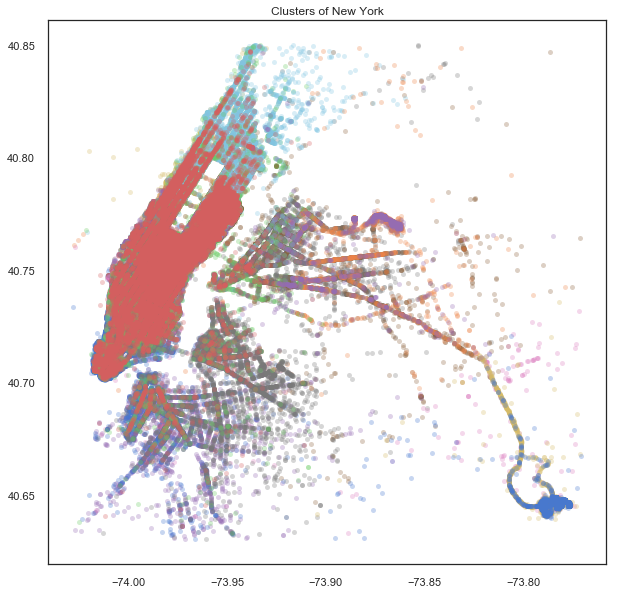

In [17]:
start = time.time()
loc_df = pd.DataFrame()
loc_df['longitude'] = data.pickup_longitude
loc_df['latitude'] = data.pickup_latitude
loc_df["dropoff_lat"] = data.dropoff_latitude
loc_df['dropoff_long'] = data.dropoff_longitude

kmeans = KMeans(n_clusters=25, random_state=2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_
plt.figure(figsize = (10,10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.3, markersize = 10)

end = time.time()
print("Time taken by above cell is {}.".format(round((end-start)/60,2)))
    
plt.title('Clusters of New York')
plt.show()

data['cluster'] = loc_df.label

### Geohash

#### Add geohash to represent location

In [18]:
start = time.time()
pickup = []
dropoff = []
for i in range(len(data)):
    
    dropoff.append(ghh.encode(data.dropoff_longitude.iloc[i], data.dropoff_latitude.iloc[i], precision=5))


data['dropoff_geo'] = dropoff
data["dropoff_geo_recode"] = data["dropoff_geo"].astype('category').cat.codes

end = time.time()
print("Time taken by above cell is {}.".format(round((end-start)/60,2)))

Time taken by above cell is 1.89.


#### Plot geohash map

In [ ]:
from IPython.display import Image
Image(filename='geohash_pickup.png', width=500, height=300)

## 4. Optimize the memory usage

In [19]:
data = data.drop(['wdsp', 'gust', 'snow_ice_pellets', 'hail', 'thunder','dropoff_geo'], axis = 1)

In [20]:
# Create a function to be calculating memory usage
def get_usage(obj):
    if isinstance(obj, pd.DataFrame):
        usage = obj.memory_usage(deep=True).sum()
    else:
        usage = obj.memory_usage(deep=True)
    return "{:03.2f} MB".format(usage / (1024**2))

# Convert object to int
obj = data.select_dtypes(include = 'object')
obj = obj.iloc[:,0:7]
obj_f32 = obj.apply(pd.to_numeric, downcast='unsigned')

# Convert int64 to int8
obj = data.select_dtypes(include = 'int64')
obj_int = obj.apply(pd.to_numeric, downcast='unsigned')

# Convert float64 to float32
obj = data.select_dtypes(include = 'float64')
obj_f = obj.apply(pd.to_numeric, downcast='float')

# Calculated the memory we reduced by down grade int and float
print("Original memory usage: ", get_usage(data))
data[obj_f32.columns] = obj_f32
data[obj_int.columns] = obj_int
data[obj_f.columns] = obj_f
print("After converting int and float memory usage: ", get_usage(data))

Original memory usage:  610.01 MB
After converting int and float memory usage:  167.02 MB


In [21]:
data.head()

,travel_time,date,month,day,pickup_hour,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,temp,visib,mxpsd,max,min,prcp,sndp,fog,rain_drizzle,haversine_distance,manhattan_distance,weekday,holiday,rush_hour,bearing,airport,dropoff_geo_recode
0,7.405229,2016-01-24,1,24,14,2016-01-24 14:01:14,2016-01-24 14:11:19,-73.976639,40.782452,-73.987427,40.770359,1,26.700001,7.4,17.1,35.099998,19.9,1.82,5.9,1,0,1.623,2.253,6,0,1,-145.955002,0,454
1,7.949856,2016-01-24,1,24,14,2016-01-24 14:55:50,2016-01-24 15:13:13,-73.986816,40.739422,-73.973244,40.762661,1,26.700001,7.4,17.1,35.099998,19.9,1.82,5.9,1,0,2.826,3.728,6,0,1,23.862000,0,459
2,7.760415,2016-01-24,1,24,14,2016-01-24 14:45:06,2016-01-24 14:59:29,-73.978760,40.745090,-73.986198,40.767422,5,26.700001,7.4,17.1,35.099998,19.9,1.82,5.9,1,0,2.561,3.110,6,0,1,-14.159000,0,455
3,6.966147,2016-01-24,1,24,14,2016-01-24 14:32:17,2016-01-24 14:38:47,-73.969902,40.765556,-73.982101,40.768295,2,26.700001,7.4,17.1,35.099998,19.9,1.82,5.9,1,0,1.072,1.332,6,0,1,-73.484001,0,455
4,7.680855,2016-01-24,1,24,14,2016-01-24 14:51:23,2016-01-24 15:04:40,-73.979858,40.771004,-73.990067,40.749317,5,26.700001,7.4,17.1,35.099998,19.9,1.82,5.9,1,0,2.560,3.271,6,0,1,-160.373001,0,470


## Modeling

In [22]:
selected_features = ['month', 'pickup_hour', 'weekday', 'holiday','rush_hour',
                     'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                     'temp', 'visib', 'mxpsd',  'prcp', 'sndp', 'fog', 'passenger_count',
                     'bearing', 'airport','manhattan_distance','haversine_distance', 'dropoff_geo_recode'
                    ]

x = data[selected_features]
y = data['travel_time']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [23]:
def train_test_model_performance(clf, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test):
    
    # Fit a model by providing X and y from training set
    clf.fit(x_train, y_train)
    print(clf)
    # Make prediction on the training data
    y_train_pred = clf.predict(x_train)

    # Make predictions on test data
    y_test_pred = clf.predict(x_test)
    
    # Evaluate
    R2_Train = clf.score(x_train,y_train)
    R2_Test = clf.score(x_test,y_test)
    RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
    RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))
#     RMSLE_Train = sqrt(mean_squared_log_error(y_train, y_train_pred))
#     RMSLE_Test = sqrt(mean_squared_log_error(y_test, y_test_pred))
    
    metric_names = ['R2','RMSE']
    metric_values_train = [R2_Train, RMSE_Train]
    metric_values_test = [R2_Test, RMSE_Test]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

In [24]:
def cv_model_performance(clf, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test):
    
    # Fit a model by providing X and y from training set
    clf.fit(x_train, y_train)
    model = clf.best_estimator_
    print(model)
    
    # Make prediction on the training data
    y_train_pred = model.predict(x_train)

    # Make predictions on test data
    y_test_pred = model.predict(x_test)
    
    # Evaluate
    R2_Train = model.score(x_train,y_train)
    R2_Test = model.score(x_test,y_test)
    RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
    RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))
    RMSLE_Train = sqrt(mean_squared_log_error(y_train, y_train_pred))
    RMSLE_Test = sqrt(mean_squared_log_error(y_test, y_test_pred))
    
    metric_names = ['R2','RMSE','RMSLE']
    metric_values_train = [R2_Train, RMSE_Train, RMSLE_Train]
    metric_values_test = [R2_Test, RMSE_Test, RMSLE_Test]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

### Random Forest

#### Cross Validation

In [ ]:
start = time.time()

# Choose the type of classifier. /
rf = RandomForestRegressor()

# Choose some parameter combinations to try
param_grid = {'n_estimators': [300,400], 
              'max_features': ['auto'], 
              'max_depth': [40,50], 
              'min_samples_split': [30, 50],
              'n_jobs':[-1]
             }

# read theory
grid_obj = GridSearchCV(rf, param_grid, cv=3, n_jobs = 8, iid=False, verbose=10, scoring='r2')
cv_model_performance(grid_obj)

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

#### Train RF

#### Feature Importance

In [ ]:
start = time.time()
# parameters = {'n_estimators': 300,
#              'max_features': 'auto',
#               'max_depth': 50,
#               'min_samples_split': 40,
#               'random_state': 2,
#               'n_jobs': -1,
#               }
# 0.899009  0.839094 25

parameters = {'n_estimators': 300,
             'max_features': 'auto',
              'max_depth': 50,
              'min_samples_split': 150,
              'random_state': 2,
              'n_jobs': -1
              }

rf = RandomForestRegressor(**parameters)
train_test_model_performance(rf)

end = time.time()
print("Time taken by above cell is {}.".format(round(end-start)/60,2))

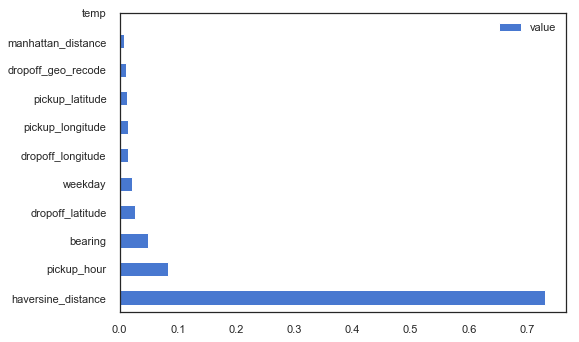

In [32]:
features = pd.DataFrame(list(zip(selected_features, rf.feature_importances_))).sort_values(by=[1], ascending=False)
features.columns = ['feature', 'value']

ax = features.iloc[0:10].plot.barh()
t = np.arange(11)
ax.set_yticks(t)
ax.set_yticklabels(features['feature'])
plt.show()

### Gradient Boosting Trees

#### Cross Validation

In [ ]:
start = time.time()
GBDT = GradientBoostingRegressor()

# Choose some parameter combinations to try
param_grid = {'n_estimators': [250, 300], 
              'max_depth': [10, 11], 
              'learning_rate': [0.2],
              'min_samples_split': [50, 55],
              'subsample':[0.9],
              'random_state': [2]
             }

# read theory
grid_obj = GridSearchCV(GBDT, param_grid, cv=3, n_jobs=8, iid=False, verbose=10, scoring='r2')
cv_model_performance(grid_obj)

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed: 301.4min


#### Train GBDT

In [33]:
start = time.time()

#Choose some parameter combinations to try
# parameters = {
#     'n_estimators': 150,
#     'max_depth': 7,
#     'learning_rate': 0.2,
#     'min_samples_split': 30,
#     'max_features': 'auto',
#     'subsample': 0.7,
#     'random_state': 2
# }

#0.797
parameters = {
    'n_estimators': 300,
    'max_depth': 9,
    'learning_rate': 0.2,
    'min_samples_split': 50,
    'subsample': 0.9,
    'random_state': 2
}

GBDT = GradientBoostingRegressor(**parameters)
train_test_model_performance(GBDT)

end = time.time()
print("Time taken by above cell is {}.".format(round((end-start)/60),2))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=9, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=50, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=2,
             subsample=0.9, verbose=0, warm_start=False)
            train      test
metrics                    
R2       0.895770  0.857926
RMSE     0.244009  0.284756
Time taken by above cell is 80.


#### Feature Improtance

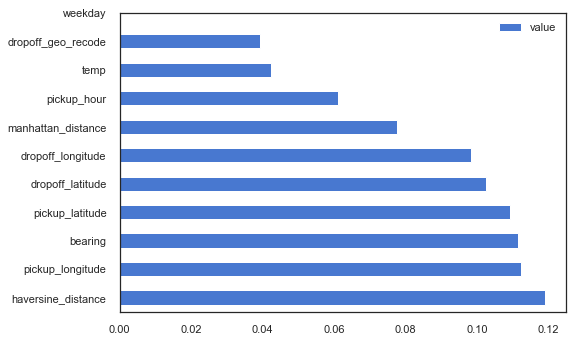

In [34]:
features = pd.DataFrame(list(zip(selected_features, GBDT.feature_importances_))).sort_values(by=[1], ascending=False)
features.columns = ['feature', 'value']
features.head(10)

ax = features.iloc[0:10].plot.barh()
t = np.arange(11)
ax.set_yticks(t)
ax.set_yticklabels(features['feature'])
plt.show()

### Extremely Gradient Boosting (XGB)

#### Spliting Train and Test Data

In [ ]:
selected_features = ['month_of_year', 'day_of_year', 'pickup_hour', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
      'dropoff_latitude', 'passenger_count',  'prcp', 'sndp', 'fog', 'weekday', 'holiday', 
                     'haversine_distance','cluster','bearing','manhattan_distance']
x = data[selected_features]
y = np.log(data['travel_time'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


In [25]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_test, label=y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

#### Grid Search CV for parameter selection

In [51]:
from sklearn.grid_search import GridSearchCV 

parameters_for_testing = {
   'min_child_weight':[10,15],
   'max_depth':[15,17],
   'alpha':[10,15]
    
}
          
xgb_model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=12,
    min_child_weight=10, subsample=0.6, colsample_bytree=0.6, nthread= 8, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, cv=3, n_jobs=8,iid=False, verbose=10,scoring='r2')
gsearch1.fit(x_train,y_train)
print (gsearch1.grid_scores_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

#### Train model 

In [26]:
start = time.time()
xgb_pars = {'min_child_weight': 15, 'eta': 0.1, 'colsample_bytree': 0.7, 
            'max_depth': 15, 'alpha' : 15,
            'subsample': 0.7,'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear','lambda':1}
model = xgb.train(xgb_pars, dtrain, 250, watchlist, early_stopping_rounds=2,
      maximize=False, verbose_eval=1)
print('Modeling RMSE %.5f' % model.best_score)

end = time.time()
print("Time taken by above cell is {}.".format(round((end-start)/60),2))

[0]	train-rmse:6.33388	valid-rmse:6.33522
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:5.70324	valid-rmse:5.70453
[2]	train-rmse:5.13592	valid-rmse:5.13717
[3]	train-rmse:4.62545	valid-rmse:4.62668
[4]	train-rmse:4.16662	valid-rmse:4.16779
[5]	train-rmse:3.75361	valid-rmse:3.75471
[6]	train-rmse:3.38247	valid-rmse:3.38354
[7]	train-rmse:3.04868	valid-rmse:3.04971
[8]	train-rmse:2.74856	valid-rmse:2.74956
[9]	train-rmse:2.47889	valid-rmse:2.47987
[10]	train-rmse:2.23658	valid-rmse:2.23751
[11]	train-rmse:2.01904	valid-rmse:2.01991
[12]	train-rmse:1.82432	valid-rmse:1.82515
[13]	train-rmse:1.6492	valid-rmse:1.65001
[14]	train-rmse:1.49256	valid-rmse:1.49334
[15]	train-rmse:1.35197	valid-rmse:1.35268
[16]	train-rmse:1.22631	valid-rmse:1.22695
[17]	train-rmse:1.11383	valid-rmse:1.11445
[18]	train-rmse:1.01351	valid-rmse:1.0141
[19]	train-rmse:0.9241	valid-rmse:0.924686
[20]	tra

[180]	train-rmse:0.269686	valid-rmse:0.277895
[181]	train-rmse:0.269546	valid-rmse:0.277803
[182]	train-rmse:0.269493	valid-rmse:0.277777
[183]	train-rmse:0.269437	valid-rmse:0.277758
[184]	train-rmse:0.269336	valid-rmse:0.277697
[185]	train-rmse:0.269263	valid-rmse:0.277662
[186]	train-rmse:0.269215	valid-rmse:0.277638
[187]	train-rmse:0.269145	valid-rmse:0.277604
[188]	train-rmse:0.269038	valid-rmse:0.277532
[189]	train-rmse:0.268971	valid-rmse:0.277507
[190]	train-rmse:0.268923	valid-rmse:0.277488
[191]	train-rmse:0.268851	valid-rmse:0.277444
[192]	train-rmse:0.268798	valid-rmse:0.277415
[193]	train-rmse:0.268753	valid-rmse:0.277398
[194]	train-rmse:0.268687	valid-rmse:0.277362
[195]	train-rmse:0.268602	valid-rmse:0.277317
[196]	train-rmse:0.268537	valid-rmse:0.277282
[197]	train-rmse:0.268481	valid-rmse:0.27725
[198]	train-rmse:0.268449	valid-rmse:0.277238
[199]	train-rmse:0.268415	valid-rmse:0.277232
[200]	train-rmse:0.268333	valid-rmse:0.277184
[201]	train-rmse:0.268229	valid-rms

#### Feature Improtance

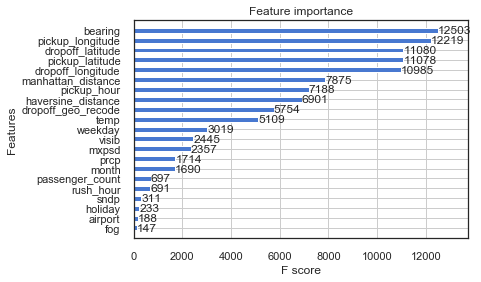

In [28]:
xgb.plot_importance(model, max_num_features=28, height=0.5)

#### Evaluate model performance

In [48]:
# Make prediction on the training data
y_train_pred = model.predict(dtrain)

# Make predictions on test data
y_test_pred = model.predict(dvalid)

# Evaluate
R2_Train = r2_score(y_train_pred, y_train)
R2_Test = r2_score(y_test_pred, y_test)
RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))

metric_names = ['R2','RMSE']
metric_values_train = [R2_Train, RMSE_Train]
metric_values_test = [R2_Test, RMSE_Test]
all_metrics = pd.DataFrame({'metrics':metric_names,
                            'train':metric_values_train,
                            'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
print(all_metrics)


            train      test
metrics                    
R2       0.851719  0.836598
RMSE     0.268905  0.281782


In [27]:
# Make prediction on the training data
y_train_pred = model.predict(dtrain)

# Make predictions on test data
y_test_pred = model.predict(dvalid)

# Evaluate
R2_Train = r2_score(y_train_pred, y_train)
R2_Test = r2_score(y_test_pred, y_test)
RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))

metric_names = ['R2','RMSE']
metric_values_train = [R2_Train, RMSE_Train]
metric_values_test = [R2_Test, RMSE_Test]
all_metrics = pd.DataFrame({'metrics':metric_names,
                            'train':metric_values_train,
                            'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
print(all_metrics)

           train      test
metrics                   
R2       0.84290  0.830409
RMSE     0.26525  0.275630


In [29]:
data.shape

(1621627, 29)

## Prediction

In [ ]:
def haversine_(lat1, lng1, lat2, lng2):
    """function to calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = round(2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d)),3)
    return(h)

def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """function to calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

def feature_engineer(data):
    start = time.time()
    
    # create distance_in_km
    data['haversine_distance'] = haversine_(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude)

    # create mahattan dist
    data['manhattan_distance'] = manhattan_distance_pd(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude)

    # create bearing
    data['bearing'] = bearing_array(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude)

    # create weekday
    data["weekday"] = data['pickup_datetime'].dt.dayofweek

    # create holiday
    us_holidays = holidays.UnitedStates()
    data['holiday'] = data['date_of_year'].apply(lambda x: 1 if x in us_holidays else 0)
    
    # K-means clustering
    location = data.loc[:, ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]
    kmeans = KMeans(n_clusters=50, random_state=123, n_init = 10, n_jobs = 4).fit(location)
    data['cluster'] = kmeans.labels_
  
    # create geo hash (clustering the pickup and dropoff spots)
#     pickup = []
    dropoff = []
    for i in range(len(data)):
        dropoff.append(ghh.encode(data.dropoff_longitude.iloc[i], data.dropoff_latitude.iloc[i], precision=5))

    data['dropoff_geo_recode'] = dropoff
    data["dropoff_geo_recode"] = data["dropoff_geo_recode"].astype('category').cat.codes

    
    end = time.time()
    print("Time taken by above function is {}.".format((end-start)/60))
    
    return(data)

In [ ]:
# Create a function to be calculating memory usage
def get_usage(obj):
    if isinstance(obj, pd.DataFrame):
        usage = obj.memory_usage(deep=True).sum()
    else:
        usage = obj.memory_usage(deep=True)
    return "{:03.2f} MB".format(usage / (1024**2))

def optimizing(data):
    start = time.time()
        
    # Convert object to int
    obj = data.select_dtypes(include = 'object')
    obj_f32 = obj.apply(pd.to_numeric, downcast='unsigned')

    # Convert int64 to int8
    obj = data.select_dtypes(include = 'int64')
    obj_int = obj.apply(pd.to_numeric, downcast='unsigned')

    # Convert float64 to float32
    obj = data.select_dtypes(include = 'float64')
    obj_f = obj.apply(pd.to_numeric, downcast='float')

    # Calculated the memory we reduced by down grade int and float
    print("Original memory usage: ", get_usage(data))
    data[obj_f32.columns] = obj_f32
    data[obj_int.columns] = obj_int
    data[obj_f.columns] = obj_f
    print("After converting int and float memory usage: ", get_usage(data))
    
    end = time.time()
    print("Time taken by above function is {}.".format((end-start)/60))
    
    return(data)

In [ ]:
def pre_processing(data, weather):
    data = data.reset_index()
    weather = weather[['day', 'month', 'prcp', 'sndp', 'fog', 'visib', 'mxpsd', 'wdsp','gust']]
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
    data['date_of_year'] = pd.to_datetime(data['pickup_datetime'].dt.date)
    data['month_of_year'] = data['pickup_datetime'].dt.month
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['day_of_year'] = data['pickup_datetime'].dt.day
    data = pd.merge(data, weather, how = 'inner', left_on = ['day_of_year','month_of_year'], right_on = ['day','month'])
    data = data.sort_values(by=['index']).reset_index()
    return(data)

#### Loading Testing Data

In [ ]:
taxi = pd.read_csv("./APM4990_final_test_data_filtered.csv")
weather_2015 = pd.read_csv("./weather_2015_cleaned.csv")

#### Pre-processing

In [ ]:
test = pre_processing(taxi, weather_2015)

#### Feature Engineer

In [ ]:
test = feature_engineer(test)

#### Data Optimiziing

In [ ]:
test = optimizing(test)

In [ ]:
selected_features = ['month_of_year', 'day_of_year', 'pickup_hour', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'cluster',
       'dropoff_latitude', 'passenger_count', 'bearing',  'prcp', 'sndp', 'fog', 'weekday', 'holiday', 'manhattan_distance','haversine_distance','dropoff_geo_recode']

test = test[selected_features]

In [ ]:
y_pred_GBDT = np.exp(GBDT.predict(test))

In [ ]:
result = pd.DataFrame({'predictions':y_pred_GBDT})

In [ ]:
result.to_csv('./result.csv',index = False)